In [1]:
# Volatility Analysis: NVIDIA vs S&P 500
# Clean recreation of key plots from volatility.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import yfinance as yf

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load volatility dataset and establish primary/extended date ranges
print("Loading volatility data...")
volatility_data = pd.read_csv('market_volatility_data.csv', index_col=0, parse_dates=True)
main_start = volatility_data.index.min()
main_end = volatility_data.index.max()
print(f"Data loaded: {len(volatility_data)} observations")
print(f"Primary date range: {main_start} to {main_end}")

# Extend start date (~90 calendar days) so 30-day rolling window has enough history before main_start
extended_start = main_start - pd.Timedelta(days=90)
print(f"\nDownloading NVDA and S&P 500 stock prices (extended): {extended_start.date()} to {main_end.date()}...")
nvda_data = yf.download("NVDA", start=extended_start.strftime('%Y-%m-%d'), end=main_end.strftime('%Y-%m-%d'), auto_adjust=True, progress=False)
sp500_data = yf.download("^GSPC", start=extended_start.strftime('%Y-%m-%d'), end=main_end.strftime('%Y-%m-%d'), auto_adjust=True, progress=False)

# Extract NVDA close prices
if isinstance(nvda_data.columns, pd.MultiIndex):
    if ('Close', 'NVDA') in nvda_data.columns:
        nvda_prices = nvda_data[('Close', 'NVDA')]
    else:
        nvda_prices = nvda_data.xs('Close', level=0, axis=1).iloc[:, 0]
else:
    nvda_prices = nvda_data['Close'] if 'Close' in nvda_data.columns else nvda_data.iloc[:, 0]

if isinstance(nvda_prices, pd.DataFrame):
    nvda_prices = nvda_prices.iloc[:, 0]

# Extract S&P 500 close prices
if isinstance(sp500_data.columns, pd.MultiIndex):
    if ('Close', '^GSPC') in sp500_data.columns:
        sp500_prices = sp500_data[('Close', '^GSPC')]
    else:
        sp500_prices = sp500_data.xs('Close', level=0, axis=1).iloc[:, 0]
else:
    sp500_prices = sp500_data['Close'] if 'Close' in sp500_data.columns else sp500_data.iloc[:, 0]

if isinstance(sp500_prices, pd.DataFrame):
    sp500_prices = sp500_prices.iloc[:, 0]

print(f"NVDA prices loaded: {len(nvda_prices)} observations")
print(f"Price range: ${nvda_prices.min():.2f} - ${nvda_prices.max():.2f}")
print(f"\nS&P 500 prices loaded: {len(sp500_prices)} observations")

# Define AI boom split date
split_date = pd.Timestamp('2022-10-01')
print(f"\nAI Boom Start Date: {split_date.strftime('%B %d, %Y')}")


Loading volatility data...
Data loaded: 1509 observations
Primary date range: 2019-01-03 00:00:00 to 2024-12-31 00:00:00

NVDA prices loaded: 1568 observations
Price range: $3.15 - $148.84

S&P 500 prices loaded: 1568 observations

AI Boom Start Date: October 01, 2022


## Plot 1: NVDA Stock Prices vs Market Volatility

This plot shows NVDA stock prices (green line) alongside S&P 500 market volatility (blue line) to visualize how market volatility affects NVDA stock prices over time, with a clear indicator of the post-AI boom period.

### Data Used for Plot 1


In [2]:
# Prepare data for Plot 1 and create dataframe (30-day rolling volatility)
# Align NVDA prices to primary window
nvda_prices_main = nvda_prices.loc[(nvda_prices.index >= main_start) & (nvda_prices.index <= main_end)]

# Calculate S&P 500 returns using extended price history
sp500_returns_ext = sp500_prices.pct_change()

# 30-day rolling historical volatility (annualized %)
sp500_vol_30d_ext = sp500_returns_ext.rolling(window=30, min_periods=30).std() * np.sqrt(252) * 100

# Align rolling volatility to primary window and ensure no gaps
sp500_vol_30d = sp500_vol_30d_ext.loc[(sp500_vol_30d_ext.index >= main_start) & (sp500_vol_30d_ext.index <= main_end)]

# Update volatility_data to use the filled 30-day series (for consistency with other plots)
volatility_data.loc[sp500_vol_30d.index, 'SP500_Vol_30d'] = sp500_vol_30d

# Create dataframe (Date as column for easy merging)
common_dates = nvda_prices_main.index.intersection(sp500_vol_30d.index)
plot1_data = pd.DataFrame({
    'Date': common_dates,
    'NVDA_Price': nvda_prices_main.loc[common_dates].values,
    'SP500_Vol_30d': sp500_vol_30d.loc[common_dates].values
})

# Ensure Date is datetime type and format consistently
plot1_data['Date'] = pd.to_datetime(plot1_data['Date'])

# Remove weekends (if any slipped in)
weekday_mask = plot1_data['Date'].dt.dayofweek < 5
plot1_data = plot1_data[weekday_mask].copy()
print(f"Removed weekends: {len(common_dates) - len(plot1_data)} weekend dates removed")
print(f"Remaining trading days: {len(plot1_data)}")
print("\n30-day rolling volatility computed with extended history to avoid initial NaNs")
print(f"First day in dataset has volatility value: {plot1_data.iloc[0]['SP500_Vol_30d']:.2f}%")

# Convert to date (no time component) for easier merging
plot1_data['Date'] = plot1_data['Date'].dt.date

# Add period indicator
plot1_data['Period'] = pd.to_datetime(plot1_data['Date']) < split_date
plot1_data['Period'] = plot1_data['Period'].map({True: 'Before AI Boom', False: 'After AI Boom'})

# For plotting, use datetime index version
plot1_data_plot = plot1_data.copy()
plot1_data_plot.set_index(pd.to_datetime(plot1_data_plot['Date']), inplace=True)



Removed weekends: 0 weekend dates removed
Remaining trading days: 1508

30-day rolling volatility computed with extended history to avoid initial NaNs
First day in dataset has volatility value: 27.24%


In [3]:
plot1_data

,Date,NVDA_Price,SP500_Vol_30d,Period
0,2019-01-03,3.173305,27.235860,Before AI Boom
1,2019-01-04,3.376611,29.055377,Before AI Boom
2,2019-01-07,3.555371,28.743268,Before AI Boom
3,2019-01-08,3.466859,28.889384,Before AI Boom
4,2019-01-09,3.535040,28.870090,Before AI Boom
...,...,...,...,...
1503,2024-12-23,139.639572,11.958357,After AI Boom
1504,2024-12-24,140.189468,12.384828,After AI Boom
1505,2024-12-26,139.899521,12.351025,After AI Boom
1506,2024-12-27,136.980164,12.784230,After AI Boom


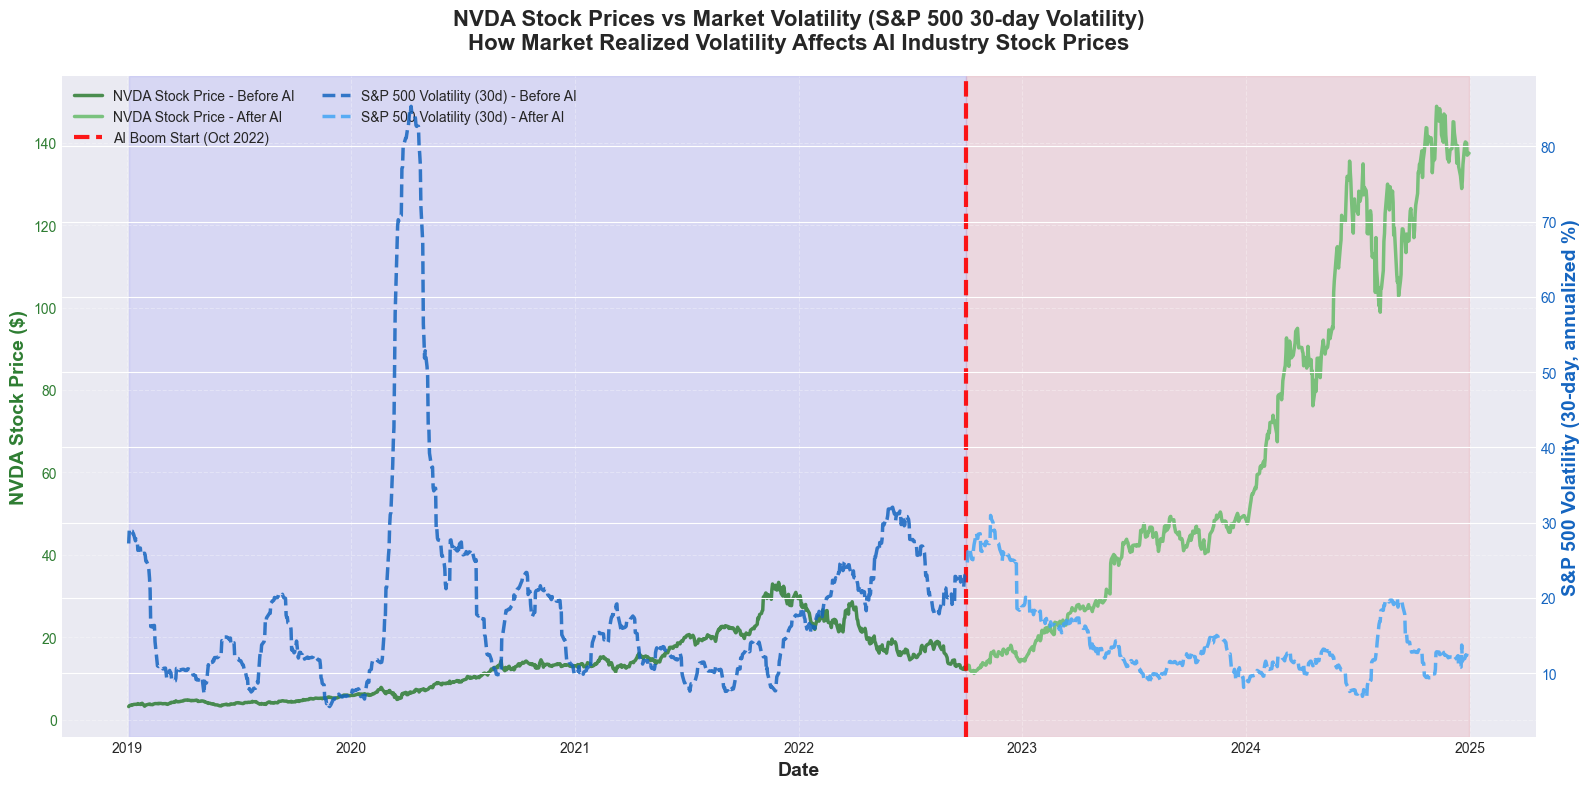

In [4]:
# Plot 1: NVDA Stock Prices vs Market Volatility
fig, ax1 = plt.subplots(figsize=(16, 8))

# Use the data from plot1_data_plot (with datetime index for plotting)
plot1_data_plot_clean = plot1_data_plot.dropna(subset=['SP500_Vol_30d'])

common_dates = plot1_data_plot_clean.index
nvda_prices_aligned = plot1_data_plot_clean['NVDA_Price']
sp500_vol_aligned = plot1_data_plot_clean['SP500_Vol_30d']

# Create period masks
before_mask = common_dates < split_date
after_mask = common_dates >= split_date

# Left y-axis: NVDA Stock Prices (green)
ax1.plot(common_dates[before_mask], nvda_prices_aligned[before_mask], 
        label='NVDA Stock Price - Before AI', color='#2E7D32', linewidth=2.5, alpha=0.85)
ax1.plot(common_dates[after_mask], nvda_prices_aligned[after_mask], 
        label='NVDA Stock Price - After AI', color='#66BB6A', linewidth=2.5, alpha=0.85)
ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
ax1.set_ylabel('NVDA Stock Price ($)', fontsize=14, fontweight='bold', color='#2E7D32')
ax1.tick_params(axis='y', labelcolor='#2E7D32')
ax1.grid(True, alpha=0.3, linestyle='--')

# Right y-axis: S&P 500 30-day Volatility (blue)
ax2 = ax1.twinx()
ax2.plot(common_dates[before_mask], sp500_vol_aligned[before_mask], 
        label='S&P 500 Volatility (30d) - Before AI', color='#1565C0', linewidth=2.5, alpha=0.85, linestyle='--')
ax2.plot(common_dates[after_mask], sp500_vol_aligned[after_mask], 
        label='S&P 500 Volatility (30d) - After AI', color='#42A5F5', linewidth=2.5, alpha=0.85, linestyle='--')
ax2.set_ylabel('S&P 500 Volatility (30-day, annualized %)', fontsize=14, fontweight='bold', color='#1565C0')
ax2.tick_params(axis='y', labelcolor='#1565C0')

# Add vertical line for AI boom start
ax1.axvline(x=split_date, color='red', linestyle='--', linewidth=3, 
          label='AI Boom Start (Oct 2022)', alpha=0.9, zorder=10)

# Add shaded regions for periods
ax1.axvspan(common_dates[0], split_date, 
          alpha=0.08, color='blue', zorder=0)
ax1.axvspan(split_date, common_dates[-1], 
          alpha=0.08, color='red', zorder=0)

# Title
ax1.set_title('NVDA Stock Prices vs Market Volatility (S&P 500 30-day Volatility)\nHow Market Realized Volatility Affects AI Industry Stock Prices', 
            fontsize=16, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, framealpha=0.95, ncol=2)

plt.tight_layout()
plt.show()


## Plot 2: Volatility Spread Over Time

This plot shows the difference between NVDA and S&P 500 volatility (NVDA_Vol - SP500_Vol) over time. This directly quantifies how much MORE volatile the AI industry is compared to the entire market and highlights when the volatility gap widens or narrows.


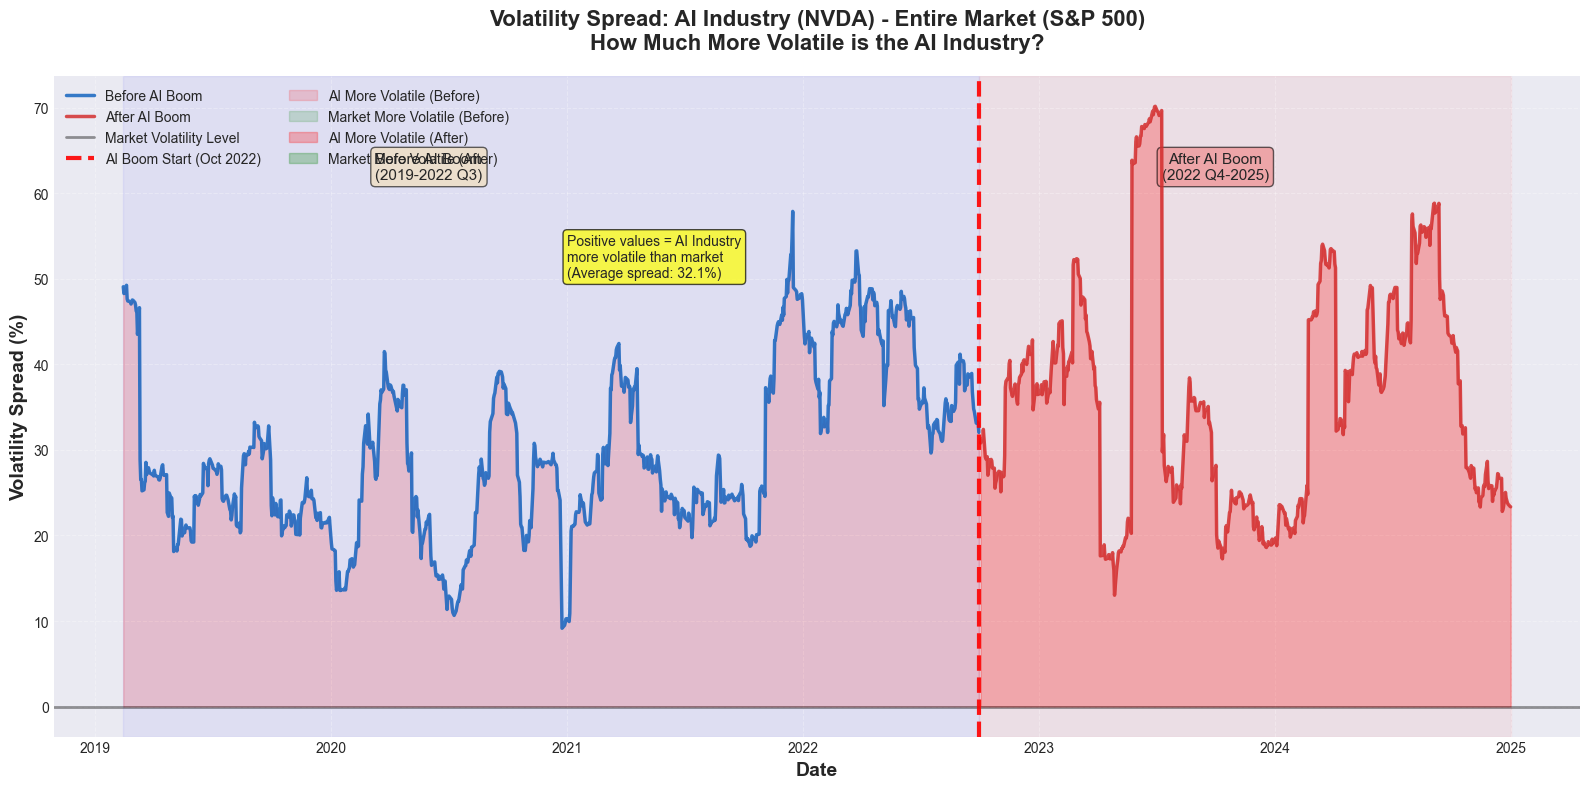

In [5]:
# Plot 2: Volatility Spread Over Time
fig, ax = plt.subplots(figsize=(16, 8))

# Calculate volatility spread
plot_data = volatility_data[['NVDA_Vol_30d', 'SP500_Vol_30d']].dropna()
volatility_spread = plot_data['NVDA_Vol_30d'] - plot_data['SP500_Vol_30d']

# Create period masks
before_mask = plot_data.index < split_date
after_mask = plot_data.index >= split_date

# Plot volatility spread with period-based coloring
ax.plot(plot_data.index[before_mask], volatility_spread[before_mask], 
        label='Before AI Boom', color='#1565C0', linewidth=2.5, alpha=0.85, zorder=5)
ax.plot(plot_data.index[after_mask], volatility_spread[after_mask], 
        label='After AI Boom', color='#D32F2F', linewidth=2.5, alpha=0.85, zorder=5)

# Add horizontal line at zero (where AI industry = market volatility)
ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.4, 
          label='Market Volatility Level', zorder=3)

# Add vertical line for AI boom start
ax.axvline(x=split_date, color='red', linestyle='--', linewidth=3, 
          label='AI Boom Start (Oct 2022)', alpha=0.9, zorder=10)

# Fill areas above and below zero
ax.fill_between(plot_data.index[before_mask], 0, volatility_spread[before_mask], 
               where=(volatility_spread[before_mask] > 0), alpha=0.15, color='red', 
               label='AI More Volatile (Before)', zorder=1)
ax.fill_between(plot_data.index[before_mask], 0, volatility_spread[before_mask], 
               where=(volatility_spread[before_mask] < 0), alpha=0.15, color='green', 
               label='Market More Volatile (Before)', zorder=1)
ax.fill_between(plot_data.index[after_mask], 0, volatility_spread[after_mask], 
               where=(volatility_spread[after_mask] > 0), alpha=0.25, color='red', 
               label='AI More Volatile (After)', zorder=1)
ax.fill_between(plot_data.index[after_mask], 0, volatility_spread[after_mask], 
               where=(volatility_spread[after_mask] < 0), alpha=0.25, color='green', 
               label='Market More Volatile (After)', zorder=1)

# Add shaded regions for periods
ax.axvspan(plot_data.index[0], split_date, 
          alpha=0.05, color='blue', zorder=0)
ax.axvspan(split_date, plot_data.index[-1], 
          alpha=0.05, color='red', zorder=0)

# Formatting
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Volatility Spread (%)', fontsize=14, fontweight='bold')
ax.set_title('Volatility Spread: AI Industry (NVDA) - Entire Market (S&P 500)\nHow Much More Volatile is the AI Industry?', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

# Add text annotations
ax.text(pd.Timestamp('2020-06-01'), ax.get_ylim()[1]*0.88, 'Before AI Boom\n(2019-2022 Q3)', 
       fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6), ha='center', va='top')
ax.text(pd.Timestamp('2023-10-01'), ax.get_ylim()[1]*0.88, 'After AI Boom\n(2022 Q4-2025)', 
       fontsize=11, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.6), ha='center', va='top')

# Add annotation explaining positive values
if volatility_spread.mean() > 0:
    ax.text(pd.Timestamp('2021-01-01'), ax.get_ylim()[1]*0.75, 
           f'Positive values = AI Industry\nmore volatile than market\n(Average spread: {volatility_spread.mean():.1f}%)', 
           fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7), ha='left', va='top')

# Add COVID-19 annotation if visible in the data
covid_date = pd.Timestamp('2020-03-15')
if plot_data.index.min() <= covid_date <= plot_data.index.max():
    covid_spread = volatility_spread.loc[volatility_spread.index.date == covid_date.date()]
    if len(covid_spread) > 0:
        ax.annotate('COVID-19\nVolatility Spike', 
                   xy=(covid_date, volatility_spread.loc[volatility_spread.index.date == covid_date.date()].values[0]),
                   xytext=(pd.Timestamp('2020-05-01'), ax.get_ylim()[1]*0.65),
                   arrowprops=dict(arrowstyle='->', color='darkred', lw=2, alpha=0.7),
                   fontsize=10, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
                   ha='left')

plt.tight_layout()
plt.show()
